# Atividade 05 - Aprendizado Supervisionado 3

Aluno: Pedro Henrique Cardoso Paulo<br>
Disciplina: HIML<br>
Professor: Helon

Nessa atividade repetiremos o processo da Atividade 04 adicionando métodos de árvore. seguiremos usando as bases de dados consideradas nas atividades 2 e 3. Nessa etapa, vamos estudar opções de busca randômica de hiperparâmetros e reamostragem.

## Passo 0 - Importando bibliotecas

In [1]:
#Desabilitando warnings
#def warn(*args, **kwargs):
#    pass
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
#warnings.warn = warn

# Pacotes padrao
import numpy as np
import pandas as pd
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from scipy import stats
import json


# Normalizadores
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Reducao de dimensionalidade
from sklearn.decomposition import PCA

# Resampling
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV

#Pipeline
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Metricas de erro
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


#Definindo random_state
rs = 85

## Passo 1 - Importando os dados

In [2]:
fname = join(getcwd(),'data','data_postAR.pkl')
with open(fname, 'rb') as file:
    X1, y = pickle.load(file)

In [3]:
print(X1.shape, y.shape)

(850, 124) (850,)


## Passo 2 - Aplicando a reamostragem

A reamostragem será feita de modo a garantir um total de 40% das amostras para teste

In [4]:
#Pequenas melhorias desde a última rodada
# 1 - Usando o parâmetro stratify pra melhorar a segregação das classes
# 2 - Estamos usando 40% só pra treino, pra deixar mais interessante o erro
size = 0.4
X1_tr, X1_te, y_tr, y_te = train_test_split(X1, y, test_size=size, random_state=rs, stratify=y)

## Passo 3 - Definindo o Pipeline a ser usado

In [5]:
def declara_Pipeline_MinMax(tupla_metodo):
    
    steps = [
        ('Scaler', MinMaxScaler()),
        ('PCA',    PCA(n_components=0.99)),
        tupla_metodo,
    ]
    return Pipeline(steps)


def declara_Pipeline_Standard(tupla_metodo):
    
    steps = [
        ('Scaler', StandardScaler()),
        ('PCA',    PCA(n_components=0.99)),
        tupla_metodo,
    ]
    return Pipeline(steps)

## Passo 4 - Listando os modelos a serem testados e definindo hiperparâmetros a tunar

Nessa etapa, vamos criar a lista dos modelos que queremos testar.

### 4.1 - Lista de modelos testados

In [6]:
models = [
    ('SoftMax', LogisticRegression(multi_class='multinomial', max_iter=5000, solver='saga', random_state=rs)),
    ('SVM',     SVC(max_iter=-1, random_state=rs)),
    ('KNN',     KNeighborsClassifier()),
    ('DT',     DecisionTreeClassifier(random_state=rs)),
    ('RF',     RandomForestClassifier(random_state=rs)),
]

n_models = len(models)


### 4.2 - Lista de parâmetros

A lista é em grande parte inspirada nos testes que fizemos na Atividade 03. Algumas variáveis que não tinha sensibilidade (como gamme e epsilon dos kernels do SVM) usei os valores do material de aula.

In [7]:
parameters = [
    [
        {
            'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
            'SoftMax__l1_ratio'          : stats.uniform(),
            'SoftMax__C'                 : stats.loguniform(1e-3, 1e3),
            'SoftMax__penalty'           : ['elasticnet']
        },
        {
            'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
            'SoftMax__penalty'           : ['none']
        },
    ],
    {
        'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'SVM__C'                     : stats.loguniform(1e-3, 1e3),
        'SVM__kernel'                : ['linear', 'poly', 'rbf', 'sigmoid'],
        'SVM__degree'                : stats.randint(2,6),
        'SVM__gamma'                 : stats.loguniform(1e-4, 1e0),
    },
    {
        'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'KNN__n_neighbors'           : stats.randint(1,100),
        'KNN__weights'               : ['uniform', 'distance']
    },
    {
        'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'DT__criterion'              : ['gini', 'entropy'],
        'DT__splitter'               : ['best', 'random'],
        'DT__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'DT__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'DT__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'DT__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'DT__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
    {
        'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'RF__n_estimators'           : stats.randint(5,100), #Numero de arvores
        'RF__criterion'              : ['gini', 'entropy'],
        #'RF__splitter'               : ['best', 'random'],
        'RF__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'RF__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'RF__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'RF__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'RF__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
]

### 4.3 - Configurando KFolds

In [8]:
kfolds = 5 # Numero de divisoes do conjunto de treino. Uma será para validação e as demais para treino
niters = 50 # Numero de vezes a reamostrar
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=rs)

## Passo 5 - Executando os modelos

Nossa comparação será realizada a partir de um loop padrão no qual extrairemos os seguintes valores:

* Tempo de execução do RandomSearchCV
* Melhores valores dos parâmetros
* Acurácia dos modelos nos conjuntos de treino e teste
* Matriz de confusão para cada caso

Iniciando avaliação do modelo: SoftMax


/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



    Tempo de execução: 1:02:28.548155
    Score treino: 1.0
    Score teste : 1.0

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.993317893040668
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:10.664830
    Score treino: 1.0
    Score teste : 1.0

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9958205364243822
        Parâmetro SVM__C: 72.88769975399788
        Parâmetro SVM__degree: 2
        Parâmetro SVM__gamma: 0.005956936202510607
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:09.061473
    Score treino: 1.0
    Score teste : 0.9941176470588236

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: distance
        Parâmetro PCA__n_components: 0.9858189335029848

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:54.804598
    Score treino: 0.9666666666666667
   

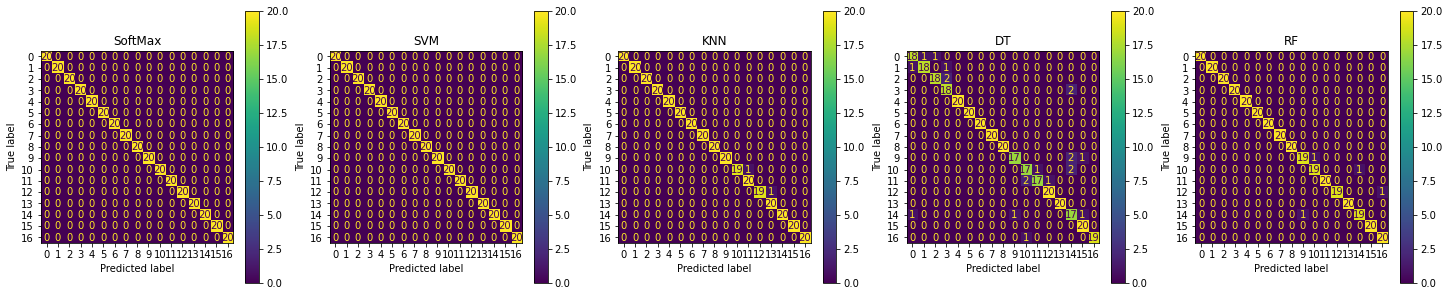

In [9]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=n_models, nrows=1, figsize=(n_models*5,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='accuracy', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    rdmsearch.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    print('    Resultados dos parâmetros:')
    for par in rdmsearch.best_params_.keys():
        print('        Parâmetro {}: {}'.format(par, rdmsearch.best_params_[par]))  
    print()
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


### 5.4 - Conclusões do Passo 5

* Quanto aos métodos anteriormente testados, as conclusões não mudaram
* O DT apresentou bons resultados, mas não foi o mais interessante
* O RF apresentou bons resultados, mas tmabém não foi o mais interessante.
* O RF teve um desempenho numérico melhor que o SoftMax, mas foi pior como preditor

## Passo 6 - Comparando os resultados com o default

### 6.1 - Executando métodos default

A execução será feita considerando-se apenas os valores padrão já definidos na declaração dos métodos (vide lista de models).

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:00:00.116734
    Score treino: 0.9921568627450981
    Score teste : 0.9970588235294118

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:00:00.013726
    Score treino: 0.996078431372549
    Score teste : 1.0

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:00:00.003521
    Score treino: 0.9862745098039216
    Score teste : 0.9941176470588236

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:00.008447
    Score treino: 1.0
    Score teste : 0.9470588235294117

Iniciando avaliação do modelo: RF

    Tempo de execução: 0:00:00.162582
    Score treino: 1.0
    Score teste : 0.9882352941176471



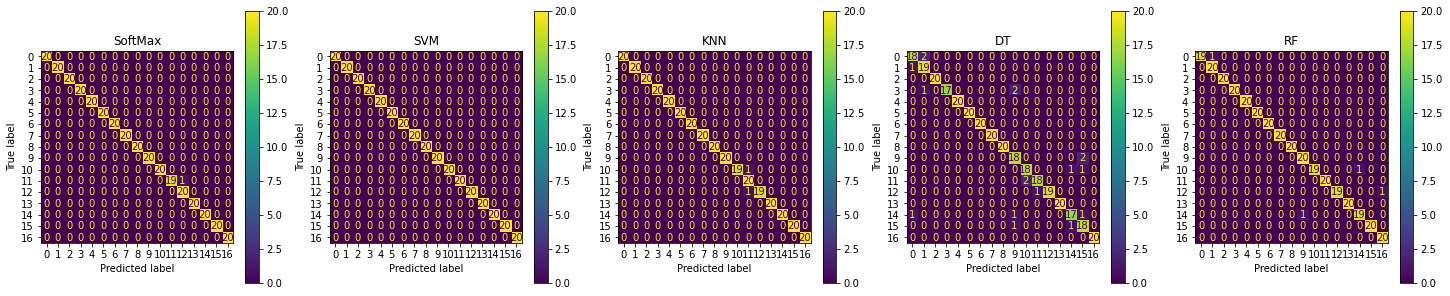

In [10]:
fig, axs = plt.subplots(ncols=n_models, nrows=1, figsize=(n_models*5,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = pipeline
    
    rdmsearch.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


### 6.2 - Conclusões

Pro nosso caso simples, os defaults ficaram bons.